# Test equivariance

### This was mainly used to debug the spherical NN


By construction the network architecture should be equivariant to rotation of the symmetry group of the icosahedron. Is it? This is what we want to find out in this notebook.

We try to proceed in the following steps:
1) We need Mnist digits in different icosahedral rotations. How do they look on the charts?

2) It would be great to do an icosahedral rotation to a already convolved feature map. Should be possible? Think about it.


Insights: 
- When applying an ico-rotation we don't expect the whole chart to be rotated into the "same" orientation channel. BUT: We do expect that - when rotated back - at least in one filter the result is the same.
- One problem for equivariance is the strided conv layer. Still need to find out why exactly
- P6convP6-layer (and previous group padding) works fine so this is not the reason

In [3]:
%matplotlib inline
import torchvision.transforms as transforms
import torch
import numpy as np
import matplotlib.pyplot as plt
import gzip
import pickle
import torch
import torch.utils.data as data_utils

In [4]:
"""Module to generate the spherical mnist data set - taken from S2CNN paper and modified"""

import gzip
import pickle
import numpy as np
import argparse
from torchvision import datasets

from icosahedron import Icosahedron, rand_rotation_icosahedron, rand_rotation_matrix, plot_voronoi, plot_voronoi_charts

NORTHPOLE_EPSILON = 1e-3


def project_sphere_on_xy_plane(grid, projection_origin):
    """ returns xy coordinates on the plane
    obtained from projecting each point of
    the spherical grid along the ray from
    the projection origin through the sphere """

    sx, sy, sz = projection_origin
    x, y, z = grid
    z = z.copy() + 1

    t = -z / (z - sz)
    qx = t * (x - sx) + x
    qy = t * (y - sy) + y

    xmin = 1/2 * (-1 - sx) + -1
    ymin = 1/2 * (-1 - sy) + -1

    # ensure that plane projection
    # ends up on southern hemisphere
    rx = (qx - xmin) / (2 * np.abs(xmin))
    ry = (qy - ymin) / (2 * np.abs(ymin))

    return rx, ry


def sample_within_bounds(signal, x, y, bounds):
    """ """
    xmin, xmax, ymin, ymax = bounds

    idxs = (xmin <= x) & (x < xmax) & (ymin <= y) & (y < ymax)

    if len(signal.shape) > 2:
        sample = np.zeros((signal.shape[0], x.shape[0], x.shape[1]))
        sample[:, idxs] = signal[:, x[idxs], y[idxs]]
    else:
        sample = np.zeros((x.shape[0], x.shape[1]))
        sample[idxs] = signal[x[idxs], y[idxs]]
    return sample


def sample_bilinear(signal, rx, ry):
    """ """

    signal_dim_x = signal.shape[1]
    signal_dim_y = signal.shape[2]

    rx *= signal_dim_x
    ry *= signal_dim_y

    # discretize sample position
    ix = rx.astype(int)
    iy = ry.astype(int)

    # obtain four sample coordinates
    ix0 = ix - 1
    iy0 = iy - 1
    ix1 = ix + 1
    iy1 = iy + 1

    bounds = (0, signal_dim_x, 0, signal_dim_y)

    # sample signal at each four positions
    signal_00 = sample_within_bounds(signal, ix0, iy0, bounds)
    signal_10 = sample_within_bounds(signal, ix1, iy0, bounds)
    signal_01 = sample_within_bounds(signal, ix0, iy1, bounds)
    signal_11 = sample_within_bounds(signal, ix1, iy1, bounds)

    # linear interpolation in x-direction
    fx1 = (ix1-rx) * signal_00 + (rx-ix0) * signal_10
    fx2 = (ix1-rx) * signal_01 + (rx-ix0) * signal_11

    # linear interpolation in y-direction
    return (iy1 - ry) * fx1 + (ry - iy0) * fx2


def project_2d_on_sphere(signal, grid, projection_origin=None):
    """ """
    if projection_origin is None:
        projection_origin = (0, 0, 2 + NORTHPOLE_EPSILON)

    rx, ry = project_sphere_on_xy_plane(grid, projection_origin)
    sample = sample_bilinear(signal, rx, ry)

    # ensure that only south hemisphere gets projected
    sample *= (grid[2] <= 1).astype(np.float64)

    # rescale signal to [0,1]
    sample_min = sample.min(axis=(1, 2)).reshape(-1, 1, 1)
    sample_max = sample.max(axis=(1, 2)).reshape(-1, 1, 1)

    sample = (sample - sample_min) / (sample_max - sample_min)
    sample *= 255
    sample = sample.astype(np.uint8)

    return sample


# if __name__ == '__main__':
#     main()


In [5]:
print("getting mnist data")

from torchvision import datasets
datasets.MNIST.resources = [
    (
    'https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz', 'f68b3c2dcbeaaa9fbdd348bbdeb94873'),
    (
    'https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz', 'd53e105ee54ea40749a09fcbcd1e9432'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz', '9fb629c4189551a2d022fa330f9573f3'),
    ('https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz', 'ec29112dd5afa0611ce80d1b7f02629c')
]

trainset = datasets.MNIST(root="MNIST_data", train=True, download=True)
testset = datasets.MNIST(root="MNIST_data", train=False, download=True)

mnist_train = {}
mnist_train['images'] = trainset.data.numpy()
mnist_train['labels'] = trainset.targets.numpy()
mnist_test = {}
mnist_test['images'] = testset.data.numpy()
mnist_test['labels'] = testset.targets.numpy()

data = mnist_train["images"].reshape(-1, 28, 28).astype(np.float64)

ico = Icosahedron(r=4, rad=1, c=np.array([0, 0, 0]))
grid = ico.get_charts_cut()
grid = grid.reshape(grid.shape[0] * grid.shape[1], grid.shape[2], grid.shape[3])

n_images = 1
projections = np.ndarray((n_images, 2, grid.shape[0], grid.shape[1]), dtype=np.uint8)
for i in range(n_images):
    ico = Icosahedron(r=4, rad=1, c=np.array([0, 0, 0]))
    grid = ico.get_charts_cut()
    grid = grid.reshape(grid.shape[0] * grid.shape[1], grid.shape[2], grid.shape[3])

    perm = rand_rotation_icosahedron()
    ico_r = Icosahedron(r=4, rad=1, c=np.array([0, 0, 0]), perm=perm)
    grid2 = ico_r.get_charts_cut()
    grid2 = grid2.reshape(grid2.shape[0] * grid2.shape[1], grid2.shape[2], grid2.shape[3])
    
    projections[i,0,...] = project_2d_on_sphere(data[i:i+1,...], grid.transpose(2, 0, 1))
    projections[i,1,...] = project_2d_on_sphere(data[i:i+1,...], grid2.transpose(2, 0, 1))    




getting mnist data


In [6]:
perm

array([11,  3,  2, 10,  6,  7,  5,  9,  8,  4,  0,  1])

In [7]:
images = projections[:,0,:,:]
images_rot = projections[:,1,:,:]
images.shape

(1, 80, 32)

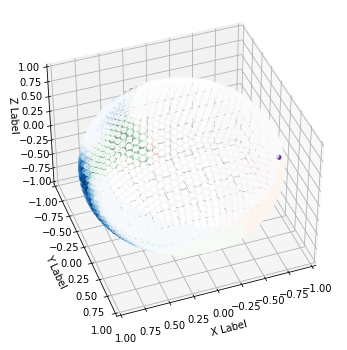

In [8]:
def markers(data):
    return 5*np.sqrt(data)+3


for i in range(len(images)):
    b = images.reshape(images.shape[0],5,-1, images.shape[-1])[i,...]
    b_rot = images_rot.reshape(images_rot.shape[0],5,-1, images_rot.shape[-1])[i,...]

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=40, azim=70)

    ico = Icosahedron(r=4,rad=1,c=np.array([0,0,0]))
    a = ico.get_charts_cut().reshape(5,-1,3)

    # ax.scatter(-a[0,:,1],-a[0,:,2],-a[0,:,0], marker='o',c=b[0,...].flatten(),cmap='Reds',label=lab)
    # ax.scatter(-a[1,:,1],-a[1,:,2],-a[1,:,0], marker='o',c=b[1,...].flatten(),cmap='Greens')
    # ax.scatter(-a[2,:,1],-a[2,:,2],-a[2,:,0], marker='o',c=b[2,...].flatten(),cmap='Blues')
    # ax.scatter(-a[3,:,1],-a[3,:,2],-a[3,:,0], marker='o',c=b[3,...].flatten(),cmap='Greys')
    # ax.scatter(-a[4,:,1],-a[4,:,2],-a[4,:,0], marker='o',c=b[4,...].flatten(),cmap='Purples')
    
    
    ax.scatter(-a[0,:,1],-a[0,:,2],-a[0,:,0], marker='o',c=b_rot[0,...].flatten(),cmap='Reds')
    ax.scatter(-a[1,:,1],-a[1,:,2],-a[1,:,0], marker='o',c=b_rot[1,...].flatten(),cmap='Greens')
    ax.scatter(-a[2,:,1],-a[2,:,2],-a[2,:,0], marker='o',c=b_rot[2,...].flatten(),cmap='Blues')
    ax.scatter(-a[3,:,1],-a[3,:,2],-a[3,:,0], marker='o',c=b_rot[3,...].flatten(),cmap='Greys')
    ax.scatter(-a[4,:,1],-a[4,:,2],-a[4,:,0], marker='o',c=b_rot[4,...].flatten(),cmap='Purples')

    
    # c = ico.corners.reshape(5,-1,3)
    # ax.scatter(-c[0,:,1],-c[0,:,2],-c[0,:,0], marker='o',c='k')
    # ax.scatter(-c[1,:,1],-c[1,:,2],-c[1,:,0], marker='o',c='k')
    # ax.scatter(-c[2,:,1],-c[2,:,2],-c[2,:,0], marker='o',c='k')
    # ax.scatter(-c[3,:,1],-c[3,:,2],-c[3,:,0], marker='o',c='k')
    # ax.scatter(-c[4,:,1],-c[4,:,2],-c[4,:,0], marker='o',c='k')
    
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    ax.axes.set_xlim3d(left=-1, right=1) 
    ax.axes.set_ylim3d(bottom=-1, top=1) 
    ax.axes.set_zlim3d(bottom=-1, top=1) 

    # plt.legend()
    plt.show()
    plt.close()
    
    

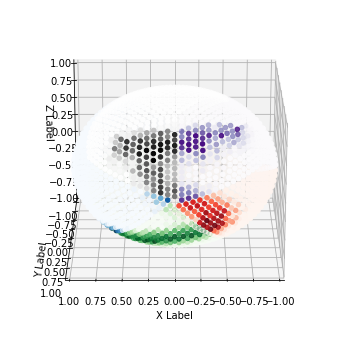

In [9]:
def markers(data):
    return 5*np.sqrt(data)+3


for i in range(len(images)):
    b = images.reshape(images.shape[0],5,-1, images.shape[-1])[i,...]
    b_rot = images_rot.reshape(images_rot.shape[0],5,-1, images_rot.shape[-1])[i,...]

    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(elev=20, azim=90)

    ico = Icosahedron(r=4,rad=1,c=np.array([0,0,0]))
    a = ico.get_charts_cut().reshape(5,-1,3)

    ax.scatter(-a[0,:,1],-a[0,:,2],-a[0,:,0], marker='o',c=b[0,...].flatten(),cmap='Reds')
    ax.scatter(-a[1,:,1],-a[1,:,2],-a[1,:,0], marker='o',c=b[1,...].flatten(),cmap='Greens')
    ax.scatter(-a[2,:,1],-a[2,:,2],-a[2,:,0], marker='o',c=b[2,...].flatten(),cmap='Blues')
    ax.scatter(-a[3,:,1],-a[3,:,2],-a[3,:,0], marker='o',c=b[3,...].flatten(),cmap='Greys')
    ax.scatter(-a[4,:,1],-a[4,:,2],-a[4,:,0], marker='o',c=b[4,...].flatten(),cmap='Purples')
    
    
    # ax.scatter(-a[0,:,1],-a[0,:,2],-a[0,:,0], marker='o',c=b_rot[0,...].flatten(),cmap='Reds')
    # ax.scatter(-a[1,:,1],-a[1,:,2],-a[1,:,0], marker='o',c=b_rot[1,...].flatten(),cmap='Greens')
    # ax.scatter(-a[2,:,1],-a[2,:,2],-a[2,:,0], marker='o',c=b_rot[2,...].flatten(),cmap='Blues')
    # ax.scatter(-a[3,:,1],-a[3,:,2],-a[3,:,0], marker='o',c=b_rot[3,...].flatten(),cmap='Greys')
    # ax.scatter(-a[4,:,1],-a[4,:,2],-a[4,:,0], marker='o',c=b_rot[4,...].flatten(),cmap='Purples')

    
    # c = ico.corners.reshape(5,-1,3)
    # ax.scatter(-c[0,:,1],-c[0,:,2],-c[0,:,0], marker='o',c='k')
    # ax.scatter(-c[1,:,1],-c[1,:,2],-c[1,:,0], marker='o',c='k')
    # ax.scatter(-c[2,:,1],-c[2,:,2],-c[2,:,0], marker='o',c='k')
    # ax.scatter(-c[3,:,1],-c[3,:,2],-c[3,:,0], marker='o',c='k')
    # ax.scatter(-c[4,:,1],-c[4,:,2],-c[4,:,0], marker='o',c='k')
    
    
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    ax.axes.set_xlim3d(left=-1, right=1) 
    ax.axes.set_ylim3d(bottom=-1, top=1) 
    ax.axes.set_zlim3d(bottom=-1, top=1) 

    # plt.legend()
    plt.show()
    plt.close()
    
    

In [10]:
b.shape

(5, 16, 32)

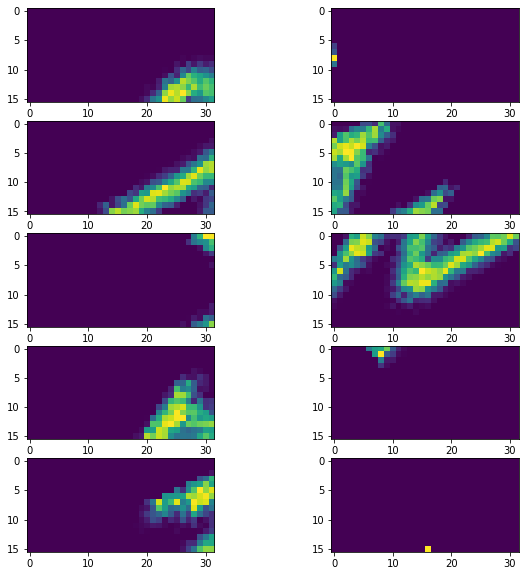

In [11]:
fig, axs = plt.subplots(5,2,figsize=(10,10))

for i in range(5):
    axs[i,0].imshow(b[i,...])
    axs[i,1].imshow(b_rot[i,...])
        

# 2. Ico-Rotate filtermaps.

In [12]:
def get_ico_rot_indices(ico, ico_r):
    """
    Returns a transformed version of the charts that results from applying a given icosahedral rotation to them.
    The current implementation is slow but does what it needs to do. Careful: Corners of the icosahedron may be
    exchanged with north and southpole, so the corresponding pixel values don't have any meaning.
    :param ico: The icosahedron in the non-rotated state
    :param ico_r: The icosahedron rotated by a rotation of the symmetrygroup of the icosahedron
    """
    charts = ico.get_charts_cut()
    charts_r = ico_r.get_charts_cut()
    
    indices = np.zeros((charts.shape),dtype='int')
    
    # figure out which element in the charts of the non-rotated ico belongs to which elements in the rotated ico.
    for i in range(charts.shape[0]):
        for j in range(charts.shape[1]):
            for k in range(charts.shape[2]):
                for l in range(charts.shape[0]):
                    for m in range(charts.shape[1]):
                        for n in range(charts.shape[2]):
                            if (charts[i,j,k,:] == charts_r[l,m,n,:]).all():
                                indices[i,j,k] = np.array([l,m,n])
    return indices

def charts_after_ico_rot(data, indices):
    """
    :param data: Data to be processed. Should be of shape (n_images, n_charts, height_chart, width_chart)
    """
    rotated_data = np.zeros(data.shape, dtype='float32')
    for i in range(data.shape[-3]): # chart coord
        for j in range(data.shape[-2]): # height on chart
            for k in range(data.shape[-1]): # width on chart
                rotated_data[(...,) + tuple(indices[i,j,k,:])] = data[...,i,j,k]
    return rotated_data




In [13]:
data = images.reshape(images.shape[0],5,-1, images.shape[-1])
data[...,0,0,0]

array([0], dtype=uint8)

In [14]:
indices_r4 = get_ico_rot_indices(ico, ico_r)
rotated_data  = charts_after_ico_rot(data, indices_r4)

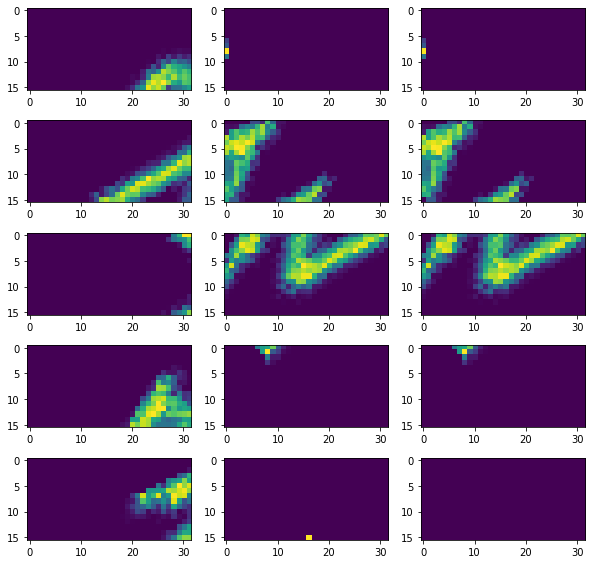

In [15]:
fig, axs = plt.subplots(5,3,figsize=(10,10))

for i in range(5):
    axs[i,0].imshow(b[i,...])
    axs[i,1].imshow(b_rot[i,...])
    axs[i,2].imshow(rotated_data[0,i,...])       

# Now test real network

In [16]:
# pylint: disable=E1101,R,C
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch
import torch.utils.data as data_utils
import gzip
import pickle
import numpy as np
from torch.autograd import Variable
import argparse
from groupy.gconv.pytorch_gconv.p6_conv_axial import P6ConvZ2, P6ConvP6
from torch.nn import BatchNorm3d as IcoBatchNorm2d
from groupy.gconv.pytorch_gconv.pooling import plane_group_spatial_orientational_max_pooling, plane_group_orientational_max_pooling

MNIST_PATH = "MNIST_data/ico_mnist_train_norot_test_ico.gz"

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

NUM_EPOCHS = 1
BATCH_SIZE = 32
LEARNING_RATE = 1e-3  # use either this or default ADAM learning rate

In [17]:
from modules import g_padding_full

In [18]:
# define some helper layers.  
class icoStridedP6ConvP6(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(icoStridedP6ConvP6, self).__init__()
        self.conv = P6ConvP6(in_channels = in_channels, 
            out_channels=out_channels, 
            kernel_size=3,
            stride=2)


    def forward(self, x):
        """
        Because we have g-padding the strided convolution is not trivial. 
        We need to add rows in order to maintain the right shape. 
        We do this by adding one row at the bottom of each chart. Afterwards we also need to g_pad the results.
        Assume x has shape (batchsize, n_channels, n_stabilizer, n_charts*height, width)
        """
        
        x = self.conv(x[...,1:,:])
        x = F.pad(x,(1,1,1,0)) # pad a single line on the bottom of the image combining the 5 charts
        x = x.view(x.shape[0], x.shape[1], x.shape[2], 5, -1, x.shape[-1])
        x = F.pad(x,(0,0,0,1))
        x = x.view(x.shape[0], x.shape[1], x.shape[2], -1, x.shape[-1])
        return x

In [19]:
# function to give dataloaders and datasets

def load_data(path, batch_size):

    with gzip.open(path, 'rb') as f:
        dataset = pickle.load(f)

    train_data = torch.from_numpy(
        dataset["train"]["images"][:, None, :, :].astype(np.float32))
    train_labels = torch.from_numpy(
        dataset["train"]["labels"].astype(np.int64))

    train_dataset = data_utils.TensorDataset(train_data, train_labels)
    train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_data = torch.from_numpy(
        dataset["test"]["images"][:, None, :, :].astype(np.float32))
    test_labels = torch.from_numpy(
        dataset["test"]["labels"].astype(np.int64))

    test_dataset = data_utils.TensorDataset(test_data, test_labels)
    test_loader = data_utils.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader, train_dataset, test_dataset

In [20]:
# reimplement the architecture from the paper:

class icoNet_original(nn.Module):

    def __init__(self):
        super(icoNet_original, self).__init__()        
        conv_n_out_channels = [8,16,16,24,24,32,64]
        fc_n_out_channels = [64,32,10]
        
        self.conv1 = P6ConvZ2(1, 
            out_channels=conv_n_out_channels[0], 
            kernel_size=3,
            padding=1)
        self.BN1 = IcoBatchNorm2d(conv_n_out_channels[0])

        self.conv2 = icoStridedP6ConvP6(in_channels=conv_n_out_channels[0],
            out_channels=conv_n_out_channels[1])
        self.BN2 = IcoBatchNorm2d(conv_n_out_channels[1])

        
        self.conv3 = P6ConvP6(in_channels=conv_n_out_channels[1],
            out_channels=conv_n_out_channels[2],
            kernel_size=3,
            padding=1)
        self.BN3 = IcoBatchNorm2d(conv_n_out_channels[2])
        
        self.conv4 = icoStridedP6ConvP6(in_channels=conv_n_out_channels[2],
            out_channels=conv_n_out_channels[3])
        self.BN4 = IcoBatchNorm2d(conv_n_out_channels[3])

        self.conv5 = P6ConvP6(in_channels=conv_n_out_channels[3],
            out_channels=conv_n_out_channels[4],
            kernel_size=3,
            padding=1)
        self.BN5 = IcoBatchNorm2d(conv_n_out_channels[4])
        
        self.conv6 = icoStridedP6ConvP6(in_channels=conv_n_out_channels[4],
            out_channels=conv_n_out_channels[5])
        self.BN6 = IcoBatchNorm2d(conv_n_out_channels[5])
        
        self.conv7 = P6ConvP6(in_channels=conv_n_out_channels[5],
            out_channels=conv_n_out_channels[6],
            kernel_size=3,
            padding=1)
        self.BN7 = IcoBatchNorm2d(conv_n_out_channels[6])
        
        self.FC1 = nn.Linear(conv_n_out_channels[6], fc_n_out_channels[0])
        self.BN_FC1 = nn.BatchNorm1d(fc_n_out_channels[0])
        self.FC2 = nn.Linear(fc_n_out_channels[0], fc_n_out_channels[1])
        self.BN_FC2 = nn.BatchNorm1d(fc_n_out_channels[1])
        
        # this is the final layer before the output
        self.FC3 = nn.Linear(fc_n_out_channels[1], fc_n_out_channels[2])
    

    def forward(self, x):
        """ Assume input has shape (batchsize, n_charts*height_chart, width)"""
        
        # first we need to pad the input with zeros, to have the right shape to apply g-padding
        x = x.view(x.shape[0], 1, 5, -1, x.shape[-1])
        x = F.pad(x,(1,1,1,1))
        x = x.view(x.shape[0], 1, 1, -1, x.shape[-1])
        
        
        #convolution 1
        g_padding_full(x, in_stab_size=1) # modifies x
        x = self.conv1(x)
        x = F.relu(self.BN1(x))
        # print("layer 1:", x.shape)        
        #convolution 2
        g_padding_full(x, in_stab_size=6)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(self.BN2(x))
        # print("layer 2:", x.shape) 
        
        #convolution 3
        g_padding_full(x, in_stab_size=6)
        x = self.conv3(x)
        x = F.relu(self.BN3(x))
        # print("layer 3:", x.shape) 
        
        #convolution 4
        g_padding_full(x, in_stab_size=6)
        x = self.conv4(x)
        x = F.relu(self.BN4(x))
        # print("layer 4:", x.shape) 
        
        #convolution 5
        g_padding_full(x, in_stab_size=6)
        x = self.conv5(x)
        x = F.relu(self.BN5(x))
        # print("layer 5:", x.shape) 
        
        #convolution 6
        g_padding_full(x, in_stab_size=6)
        x = self.conv6(x)
        x = F.relu(self.BN6(x))
        # print("layer 6:", x.shape) 
        
        #convolution 7
        g_padding_full(x, in_stab_size=6)
        x = self.conv7(x)
        x = F.relu(self.BN7(x))
        # print("layer 7:", x.shape) 
        
        # pool over orientations and space
        g_padding_full(x, in_stab_size=6)
        x = plane_group_spatial_orientational_max_pooling(x)       
        
        # FC1:
        x = F.relu(self.BN_FC1(self.FC1(x)))
        
        # FC2:
        x = F.relu(self.BN_FC2(self.FC2(x)))
        
        # FC3: (final layer, so no BN and ReLU)
        x = self.FC3(x)
        
        return x

In [21]:
train_loader, test_loader, train_dataset, _ = load_data(
    MNIST_PATH, BATCH_SIZE)

classifier = icoNet_original()

classifier.to(DEVICE)

print("#params", sum(x.numel() for x in classifier.parameters()))

criterion = nn.CrossEntropyLoss()
criterion = criterion.to(DEVICE)

optimizer = torch.optim.Adam(
    classifier.parameters(), lr=LEARNING_RATE)

for epoch in range(NUM_EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        classifier.train()

        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = classifier(images)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        print('\rEpoch [{0}/{1}], Iter [{2}/{3}] Loss: {4:.4f}'.format(
            epoch+1, NUM_EPOCHS, i+1, len(train_dataset)//BATCH_SIZE,
            loss.item()), end="")
    print("")
    correct = 0
    total = 0
    for images, labels in test_loader:

        classifier.eval()

        with torch.no_grad():
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = classifier(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).long().sum().item()

    print('Test Accuracy: {0}'.format(100 * correct / total))

#params 232089
Epoch [1/1], Iter [1875/1875] Loss: 0.1266
Test Accuracy: 98.01


In [23]:
def get_unpadded_charts(x):
        """
        tensor x has shape (batchsize, n_channels, n_stabilizer, n_charts*height, width)
        """
        xs = x.shape
        assert len(xs) == 5
        res = x.view(xs[0], xs[1], xs[2], 5, -1, xs[-1])
        res = res[...,1:-1,1:-1]
        return res

## Walk through network step by step and for every step check if we are still equivariant.

### 1 Initial input

In [24]:
x = torch.from_numpy(projections.astype('float32').reshape(2,1,1,80,32))

torch.Size([5, 16, 32])


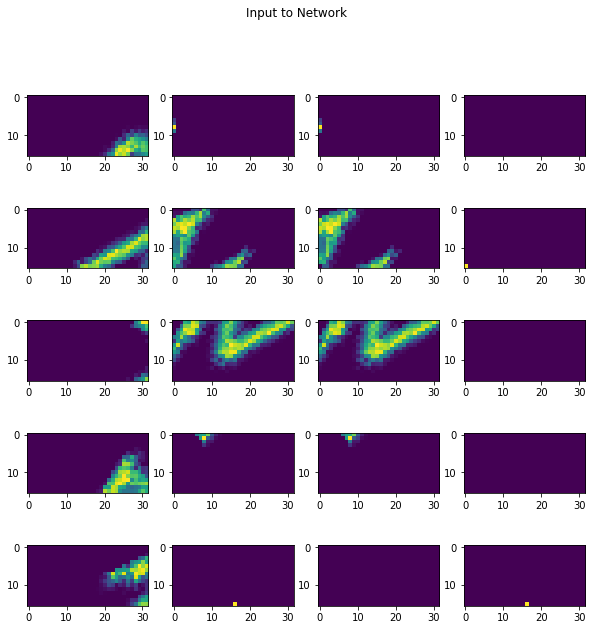

In [25]:
x = x.view(x.shape[0],1,1,5,-1,x.shape[-1])

fig, axs = plt.subplots(5,4,figsize=(10,10))
print(x[0,0,0,...].shape)
rot_x = charts_after_ico_rot(x[0,0,0,...], indices_r4)

for i in range(5):
    axs[i,0].imshow(x[0,0,0,i,...])
    axs[i,1].imshow(x[1,0,0,i,...])
    axs[i,2].imshow(rot_x[i,...])       
    axs[i,3].imshow(x[1,0,0,i,...] - rot_x[i,...])    
    
plt.suptitle("Input to Network")
plt.show()
plt.close()

### 2 After zero-padding

In [26]:
x = x.view(x.shape[0], 1, 5, -1, x.shape[-1])
x = F.pad(x,(1,1,1,1))
x = x.view(x.shape[0], 1, 1, -1, x.shape[-1])

In [27]:
y = get_unpadded_charts(x)

In [28]:
y.shape

torch.Size([2, 1, 1, 5, 16, 32])

torch.Size([5, 16, 32])


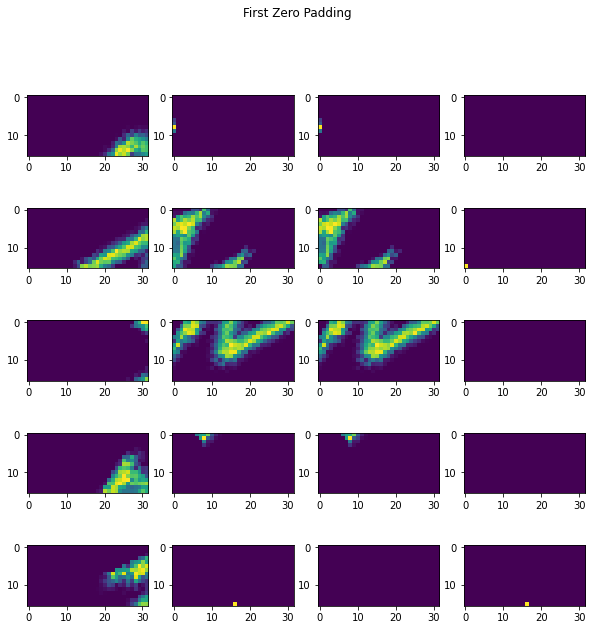

In [29]:
y = y.view(y.shape[0], 1, 1, 5, -1, y.shape[-1])

fig, axs = plt.subplots(5,4,figsize=(10,10))
print(y[0,0,0,...].shape)
rot_y = charts_after_ico_rot(y[0,0,0,...], indices_r4)

for i in range(5):
    axs[i,0].imshow(y[0,0,0,i,...])
    axs[i,1].imshow(y[1,0,0,i,...])
    axs[i,2].imshow(rot_y[i,...])      
    axs[i,3].imshow(y[1,0,0,i,...] - rot_y[i,...])
    
plt.suptitle("First Zero Padding")
plt.show()
plt.close()

### 3 After g-padding

In [30]:
x = x.view(x.shape[0],1, -1, x.shape[-1])
g_padding_full(x, in_stab_size=1) # modifies x
x = x.view(x.shape[0], 1,1, -1, x.shape[-1])

In [31]:
y = get_unpadded_charts(x)

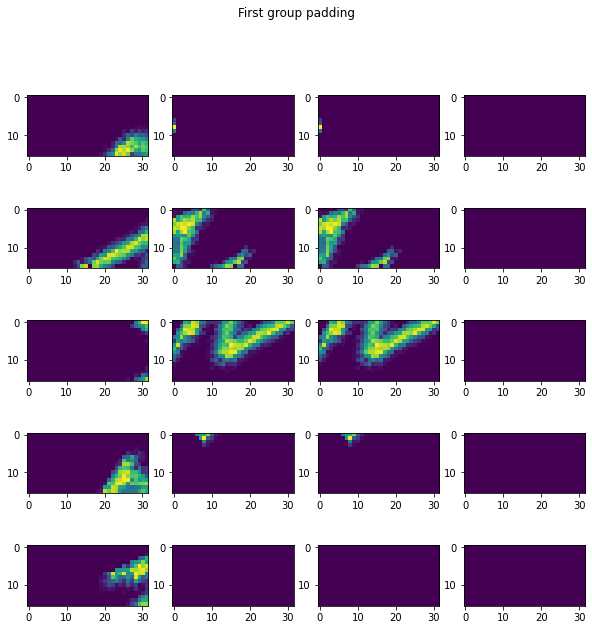

In [32]:
y = y.view(y.shape[0],1,1,5,-1,y.shape[-1])

fig, axs = plt.subplots(5,4,figsize=(10,10))

rot_y = charts_after_ico_rot(y[0,0,0,...],  indices_r4)

for i in range(5):
    axs[i,0].imshow(y[0,0,0,i,...])
    axs[i,1].imshow(y[1,0,0,i,...])
    axs[i,2].imshow(rot_y[i,...])       
    axs[i,3].imshow(y[1,0,0,i,...] - rot_y[i,...])
    
plt.suptitle("First group padding")
plt.show()
plt.close()

In [33]:
for i in range(y.shape[-2]):
    for j in range(y.shape[-1]):
        for k in range(5):
            a = np.sort(y[1,0,:,k,i,j])
            b = np.sort(rot_y.reshape((1,)+tuple(rot_y.shape))[:,k,i,j])
            if not (np.isclose(a,b)).all():
                print("ijk =", i,j,k, "\n","arrays:", a,"\n",b)

### 4 after first convolutional layer

In [34]:
x = x.view(x.shape[0], 1, -1, x.shape[-1])
x = classifier.conv1(x.to(DEVICE))

In [35]:
y = get_unpadded_charts(x).cpu().detach()

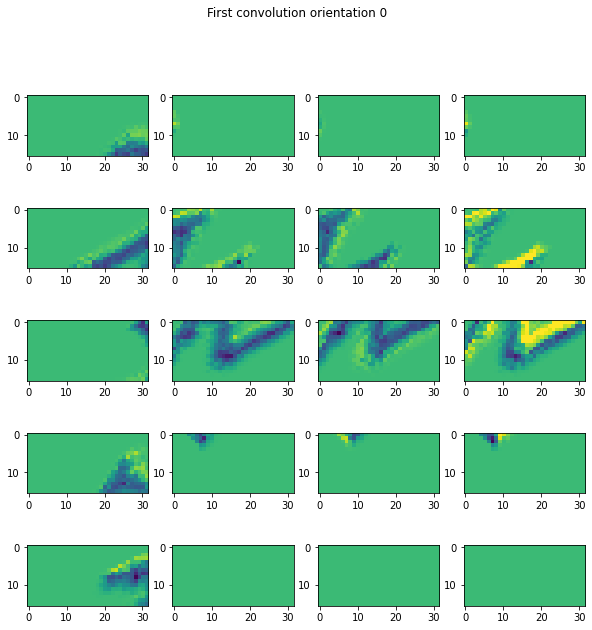

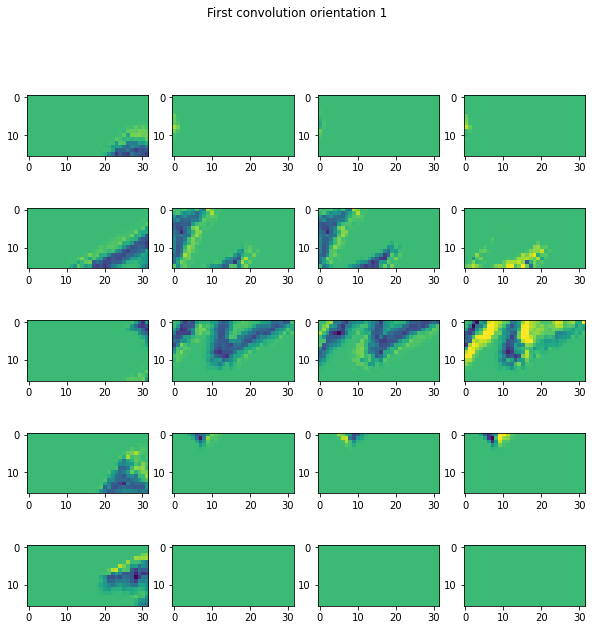

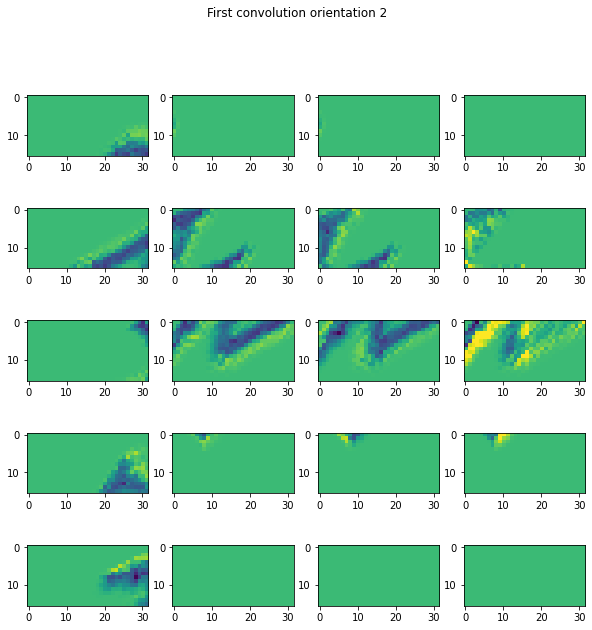

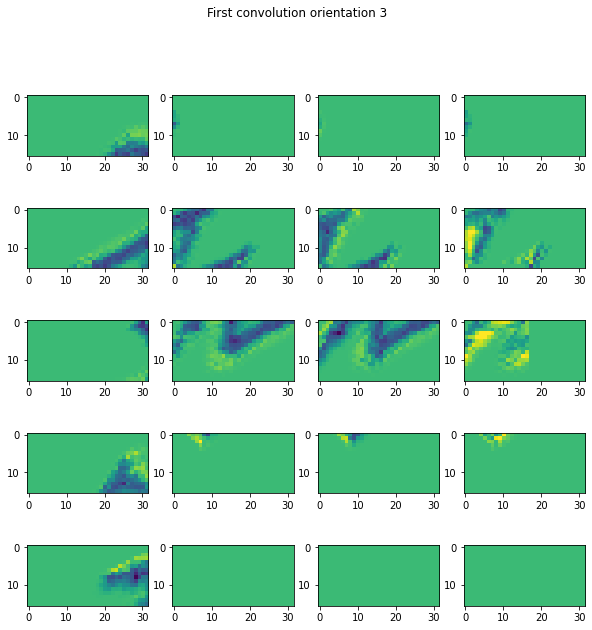

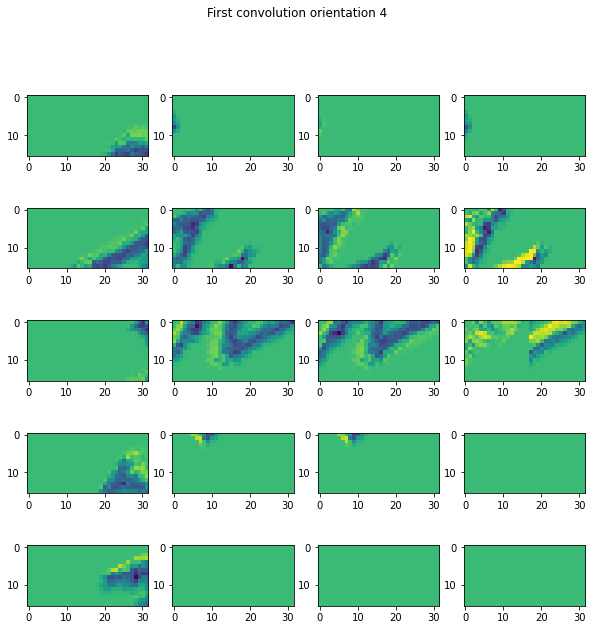

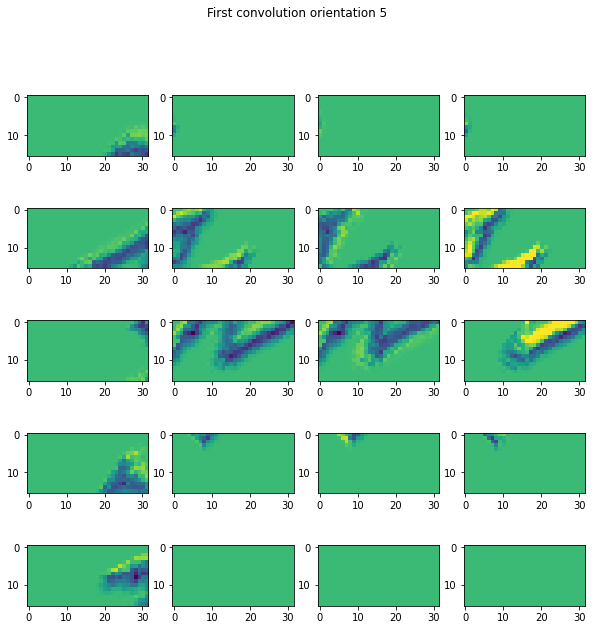

In [36]:
vmin = np.amin(y[:,0,...].numpy())
vmax = np.amax(y[:,0,...].numpy())

y = y.view(y.shape[0],y.shape[1],y.shape[2],5,-1,y.shape[-1])





for j in range(6):
    fig, axs = plt.subplots(5,4,figsize=(10,10))
    
    rot_y = charts_after_ico_rot(y[0,0,...], indices_r4)
    for i in range(5):
        axs[i,0].imshow(y[0,0,0,i,...], vmin=vmin, vmax=vmax)
        axs[i,1].imshow(y[1,0,j,i,...], vmin=vmin, vmax=vmax)
        axs[i,2].imshow(rot_y[0,i,...], vmin=vmin, vmax=vmax)       
        axs[i,3].imshow(y[1,0,j,i,...] - rot_y[0,i,...], vmin=vmin, vmax=vmax)
    
    plt.suptitle("First convolution orientation {}".format(j))
    plt.show()
    plt.close()

In [37]:
for i in range(y.shape[-2]):
    for j in range(y.shape[-1]):
        for k in range(5):
            a = np.sort(y[1,0,:,k,i,j])
            b = np.sort(rot_y[:,k,i,j])
            if not (np.isclose(a,b)).all():
                print("ijk =", i,j,k, "\n","arrays:", a,"\n",b)

ijk = 0 3 2 
 arrays: [-99.96097    -87.64973    -68.759476   -28.794834    -0.23200536
  31.428493  ] 
 [-99.96097   -87.64973   -68.75948   -28.794836   -0.2320025  31.428495 ]
ijk = 0 8 2 
 arrays: [-52.742496   -45.747597   -42.591946   -10.4446      -7.477973
  -0.08984684] 
 [-52.742493   -45.74759    -42.59195    -10.444604    -7.477973
  -0.08984589]
ijk = 1 4 3 
 arrays: [-0.120826 -0.120826 -0.120826 -0.120826 -0.120826 -0.120826] 
 [-0.12082791 -0.12082695 -0.12082624 -0.120826   -0.12082504 -0.12082504]
ijk = 1 12 1 
 arrays: [-1.7676166e+00 -8.1322098e-01 -4.0360443e-02 -7.6346844e-04
  1.9232559e-01  1.0326948e+00] 
 [-1.7676167e+00 -8.1322116e-01 -4.0359974e-02 -7.6343864e-04
  1.9232556e-01  1.0326951e+00]
ijk = 2 2 1 
 arrays: [-9.6060921e+01 -7.0466370e+01 -5.4577812e+01 -4.7528973e+01
 -1.2205887e+01  5.6207255e-03] 
 [-9.6060928e+01 -7.0466377e+01 -5.4577816e+01 -4.7528976e+01
 -1.2205884e+01  5.6150034e-03]
ijk = 2 8 3 
 arrays: [-80.178894   -68.42113    -24.49054

### 5 after first ReLu and batchnorm

In [38]:
x = F.relu(classifier.BN1(x))

In [39]:
y = get_unpadded_charts(x).cpu().detach()

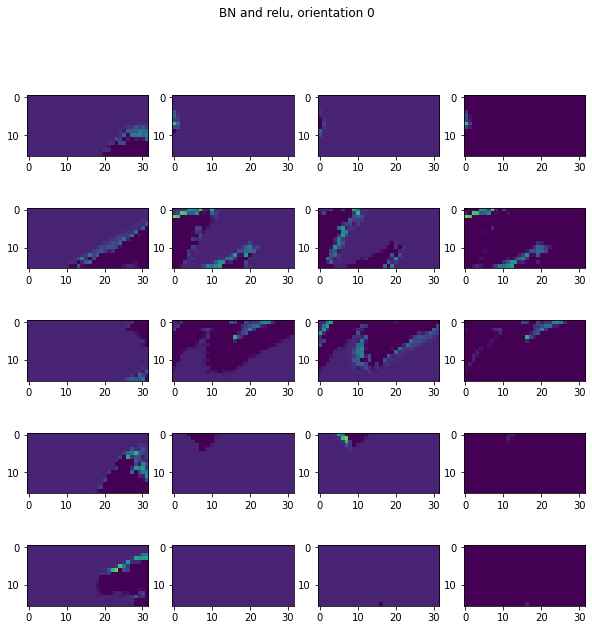

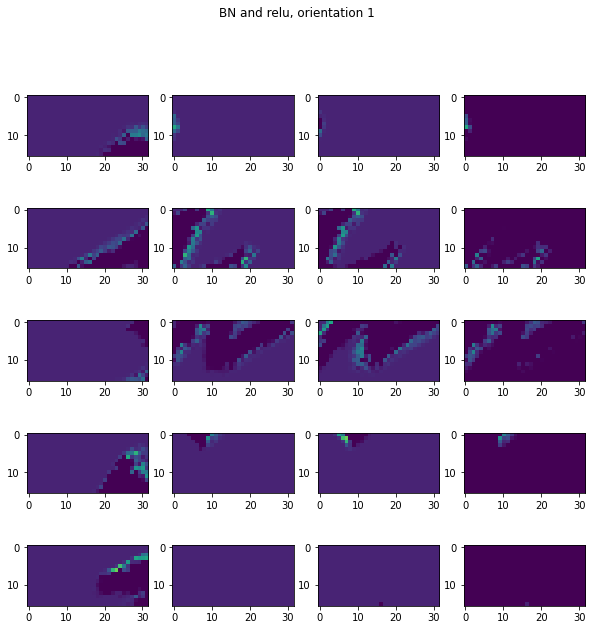

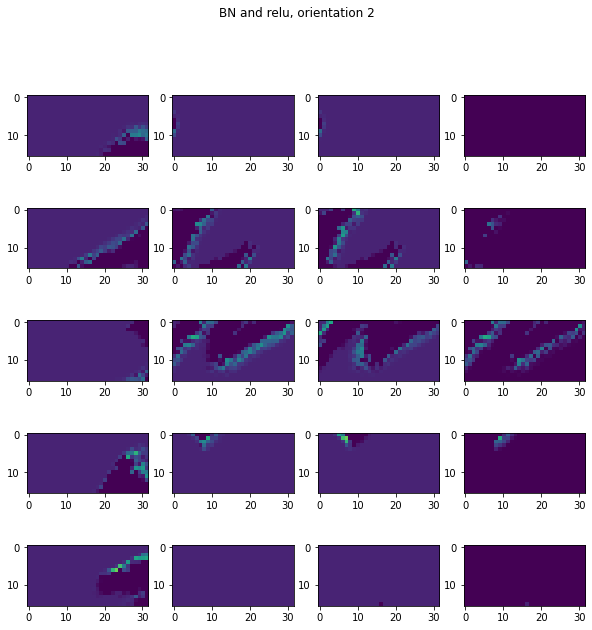

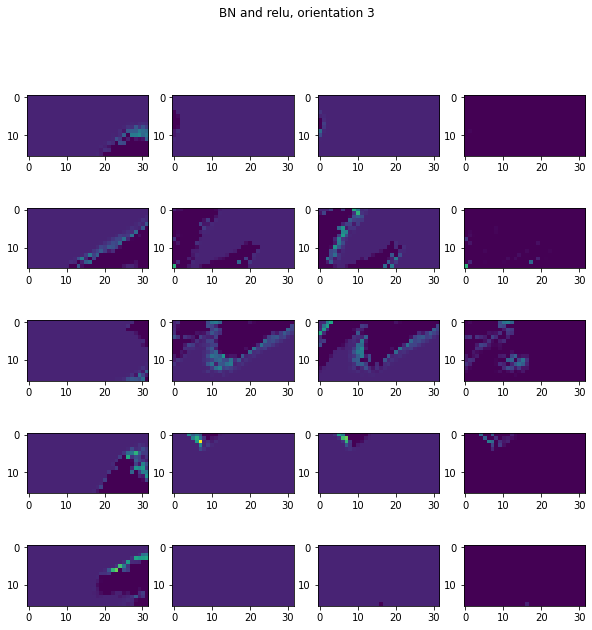

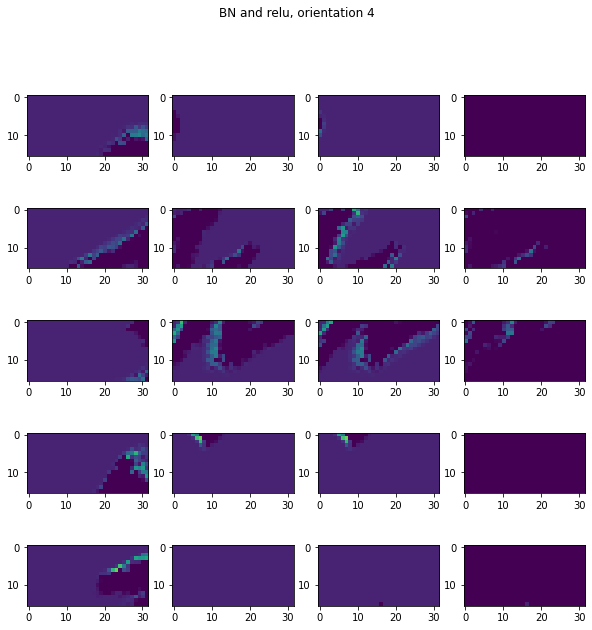

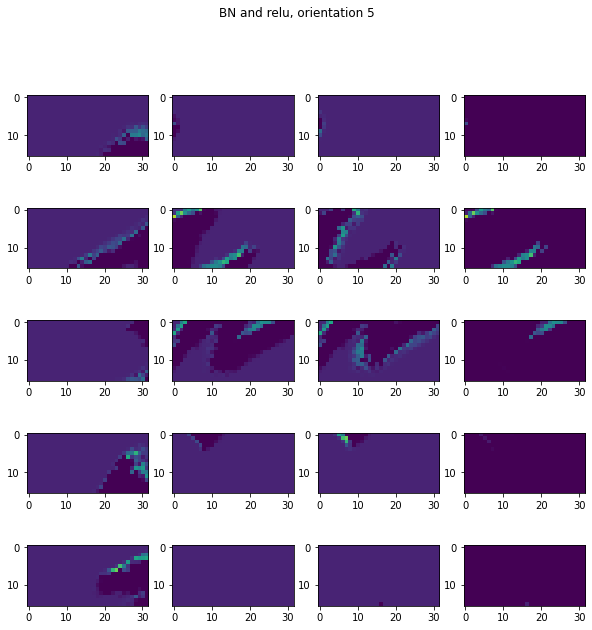

In [40]:
vmin = np.amin(y[:,0,...].numpy())
vmax = np.amax(y[:,0,...].numpy())

y = y.view(y.shape[0],y.shape[1],y.shape[2],5,-1,y.shape[-1])


for j in range(6):
    fig, axs = plt.subplots(5,4,figsize=(10,10))
    
    rot_y = charts_after_ico_rot(y[0,0,...], indices_r4)
    for i in range(5):
        axs[i,0].imshow(y[0,0,0,i,...], vmin=vmin, vmax=vmax)
        axs[i,1].imshow(y[1,0,j,i,...], vmin=vmin, vmax=vmax)
        axs[i,2].imshow(rot_y[0,i,...], vmin=vmin, vmax=vmax)       
        axs[i,3].imshow(y[1,0,j,i,...] - rot_y[0,i,...], vmin=vmin, vmax=vmax)
    
    plt.suptitle("BN and relu, orientation {}".format(j))
    plt.show()
    plt.close()

In [41]:
for i in range(y.shape[-2]):
    for j in range(y.shape[-1]):
        for k in range(5):
            a = np.sort(y[1,0,:,k,i,j])
            b = np.sort(rot_y[:,k,i,j])
            if not (np.isclose(a,b)).all():
                print("ijk =", i,j,k, "\n","arrays:", a,"\n",b)

ijk = 4 16 2 
 arrays: [0.         0.         0.         0.01116784 0.559245   2.1654115 ] 
 [0.         0.         0.         0.01116772 0.55924493 2.165412  ]
ijk = 5 16 2 
 arrays: [0.         0.         0.         0.         0.02108677 0.3295031 ] 
 [0.         0.         0.         0.         0.02108714 0.32950285]
ijk = 6 5 1 
 arrays: [0.         0.         0.         0.         0.00494935 0.09564682] 
 [0.         0.         0.         0.         0.00494947 0.09564668]
ijk = 15 0 1 
 arrays: [0.        0.        0.        0.        0.9797519 2.1822515] 
 [0. 0. 0. 0. 0. 0.]
ijk = 15 16 1 
 arrays: [0.         0.         0.         0.         0.         0.65205926] 
 [0.        0.        0.        0.        0.        0.5093093]
ijk = 15 16 4 
 arrays: [0.33943373 0.33943373 0.33943373 0.33943373 0.33943373 0.33943373] 
 [0. 0. 0. 0. 0. 0.]


 Seems fair enough apart from pixel 15,0,0  (which shouldn't be important I hope)... let's see after next gpadding.

### 6 2nd g-padding

In [42]:
g_padding_full(x, in_stab_size=6)

In [43]:
y = get_unpadded_charts(x).cpu().detach()

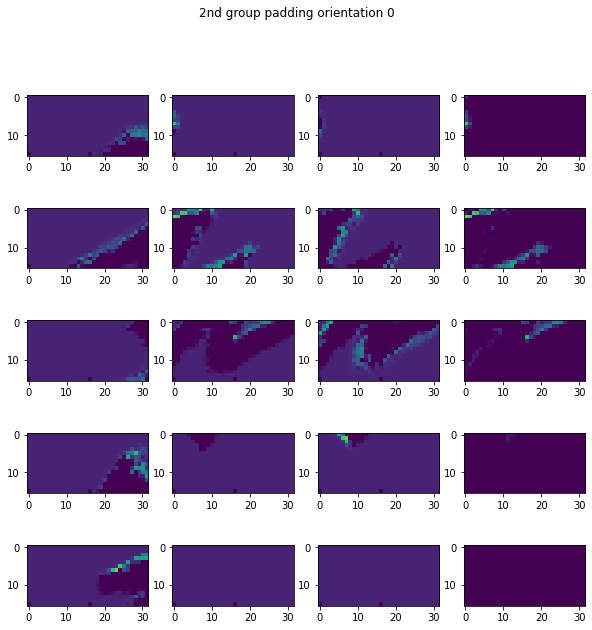

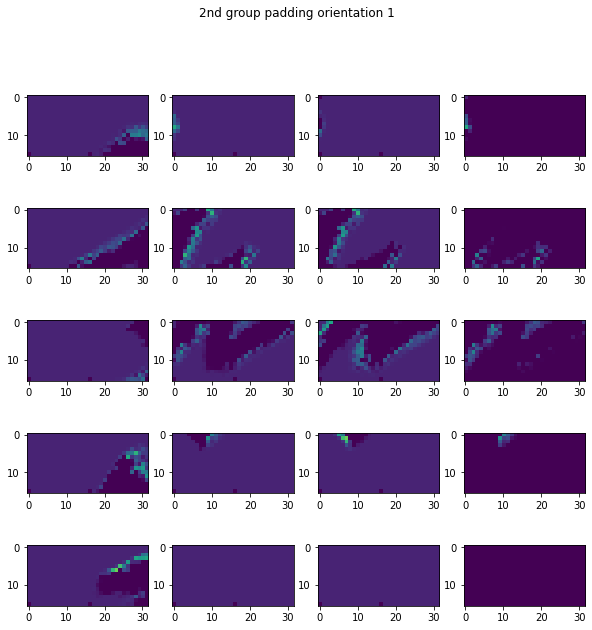

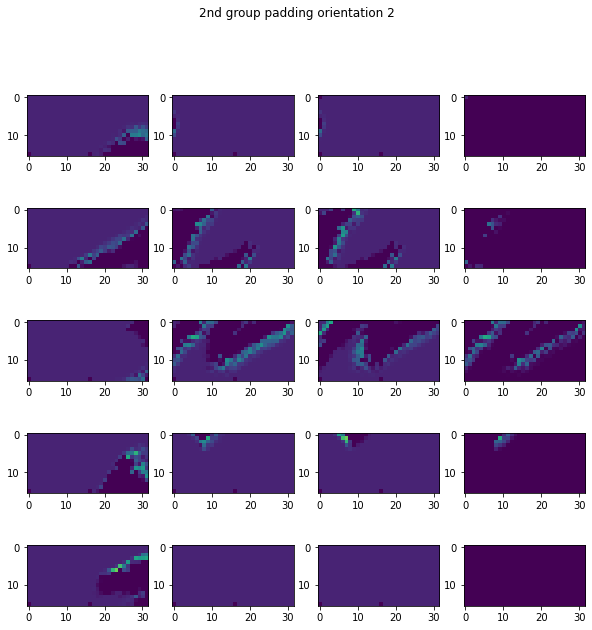

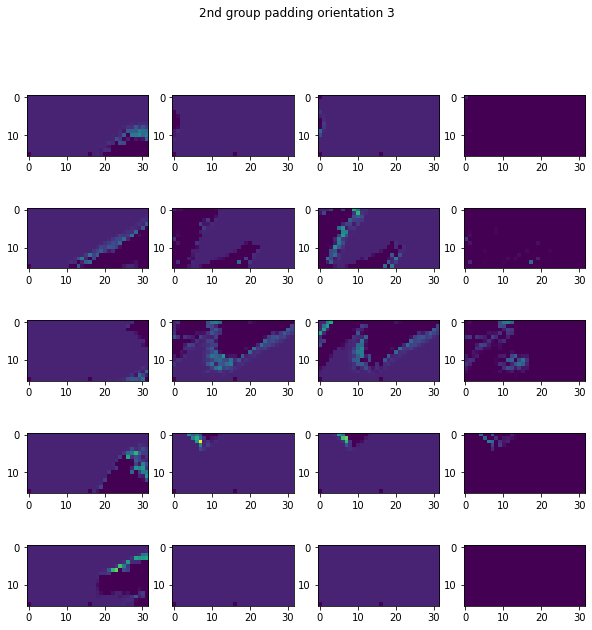

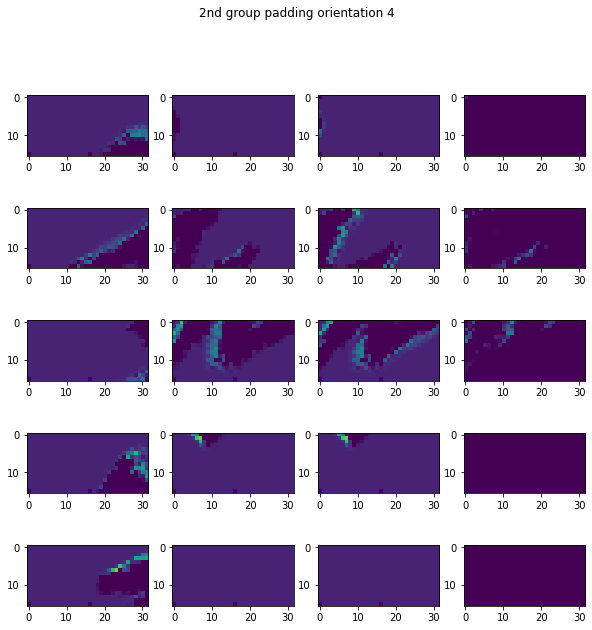

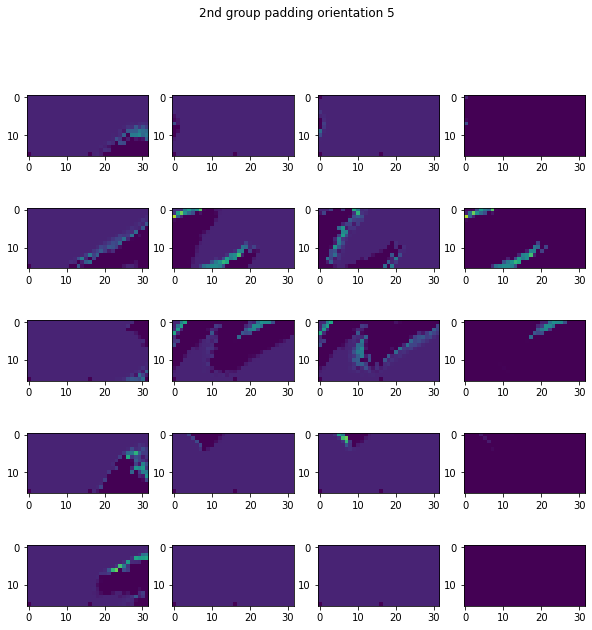

In [44]:
vmin = np.amin(y[:,0,...].numpy())
vmax = np.amax(y[:,0,...].numpy())

y = y.view(y.shape[0],y.shape[1],y.shape[2],5,-1,y.shape[-1])


for j in range(6):
    fig, axs = plt.subplots(5,4,figsize=(10,10))
    
    rot_y = charts_after_ico_rot(y[0,0,...], indices_r4)
    for i in range(5):
        axs[i,0].imshow(y[0,0,0,i,...], vmin=vmin, vmax=vmax)
        axs[i,1].imshow(y[1,0,j,i,...], vmin=vmin, vmax=vmax)
        axs[i,2].imshow(rot_y[0,i,...], vmin=vmin, vmax=vmax)       
        axs[i,3].imshow(y[1,0,j,i,...] - rot_y[0,i,...], vmin=vmin, vmax=vmax)
    
    plt.suptitle("2nd group padding orientation {}".format(j))
    plt.show()
    plt.close()

In [45]:
for i in range(y.shape[-2]):
    for j in range(y.shape[-1]):
        for k in range(5):
            a = np.sort(y[1,0,:,k,i,j])
            b = np.sort(rot_y[:,k,i,j])
            if not (np.isclose(a,b)).all():
                print("ijk =", i,j,k, "\n","arrays:", a,"\n",b)

ijk = 0 0 0 
 arrays: [0.33943373 0.33943373 0.33943373 0.33943373 0.33943373 0.33943373] 
 [0. 0. 0. 0. 0. 0.]
ijk = 4 16 2 
 arrays: [0.         0.         0.         0.01116784 0.559245   2.1654115 ] 
 [0.         0.         0.         0.01116772 0.55924493 2.165412  ]
ijk = 5 16 2 
 arrays: [0.         0.         0.         0.         0.02108677 0.3295031 ] 
 [0.         0.         0.         0.         0.02108714 0.32950285]
ijk = 6 5 1 
 arrays: [0.         0.         0.         0.         0.00494935 0.09564682] 
 [0.         0.         0.         0.         0.00494947 0.09564668]


looks very solid. Still: What is the origin of the discrepancies? Most likely the conv layer.

### 6a test p6convp6

In [46]:
# x = classifier.conv1a(x)

In [47]:
# x = F.relu(classifier.BN1a(x))
# g_padding_full(x, in_stab_size=6)

In [48]:
# y = get_unpadded_charts(x).cpu().detach()

In [49]:
"""
vmin = np.amin(y[:,0,...].numpy())
vmax = np.amax(y[:,0,...].numpy())

y = y.view(y.shape[0],y.shape[1],y.shape[2],5,-1,y.shape[-1])


for j in range(6):
    fig, axs = plt.subplots(5,4,figsize=(10,10))
    
    rot_y = charts_after_ico_rot(y[0,0,...], indices_r4)
    for i in range(5):
        axs[i,0].imshow(y[0,0,0,i,...], vmin=vmin, vmax=vmax)
        axs[i,1].imshow(y[1,0,j,i,...], vmin=vmin, vmax=vmax)
        axs[i,2].imshow(rot_y[0,i,...], vmin=vmin, vmax=vmax)       
        axs[i,3].imshow(y[1,0,j,i,...] - rot_y[0,i,...], vmin=vmin, vmax=vmax)
    
    plt.suptitle("2nd group padding orientation {}".format(j))
    plt.show()
    plt.close()
"""

'\nvmin = np.amin(y[:,0,...].numpy())\nvmax = np.amax(y[:,0,...].numpy())\n\ny = y.view(y.shape[0],y.shape[1],y.shape[2],5,-1,y.shape[-1])\n\n\nfor j in range(6):\n    fig, axs = plt.subplots(5,4,figsize=(10,10))\n    \n    rot_y = charts_after_ico_rot(y[0,0,...], indices_r4)\n    for i in range(5):\n        axs[i,0].imshow(y[0,0,0,i,...], vmin=vmin, vmax=vmax)\n        axs[i,1].imshow(y[1,0,j,i,...], vmin=vmin, vmax=vmax)\n        axs[i,2].imshow(rot_y[0,i,...], vmin=vmin, vmax=vmax)       \n        axs[i,3].imshow(y[1,0,j,i,...] - rot_y[0,i,...], vmin=vmin, vmax=vmax)\n    \n    plt.suptitle("2nd group padding orientation {}".format(j))\n    plt.show()\n    plt.close()\n'

In [50]:
"""
for i in range(y.shape[-2]):
    for j in range(y.shape[-1]):
        for k in range(5):
            a = np.sort(y[1,0,:,k,i,j])
            b = np.sort(rot_y[:,k,i,j])
            if not (np.isclose(a,b)).all():
                print("ijk =", i,j,k, "\n","arrays:", a,"\n",b)
"""

'\nfor i in range(y.shape[-2]):\n    for j in range(y.shape[-1]):\n        for k in range(5):\n            a = np.sort(y[1,0,:,k,i,j])\n            b = np.sort(rot_y[:,k,i,j])\n            if not (np.isclose(a,b)).all():\n                print("ijk =", i,j,k, "\n","arrays:", a,"\n",b)\n'

### 7 first strided conv.

In [51]:
g_padding_full(x, in_stab_size=6)
x = classifier.conv2(x)
g_padding_full(x, in_stab_size=6)
# print(x.shape)

In [52]:
y = get_unpadded_charts(x).cpu().detach()

In [53]:
# now we need new indices because we are at a lower resolution
ico = Icosahedron(r=3, rad=1, c=np.array([0, 0, 0]))
ico_r = Icosahedron(r=3, rad=1, c=np.array([0, 0, 0]), perm=perm)

indices_r3 = get_ico_rot_indices(ico, ico_r)

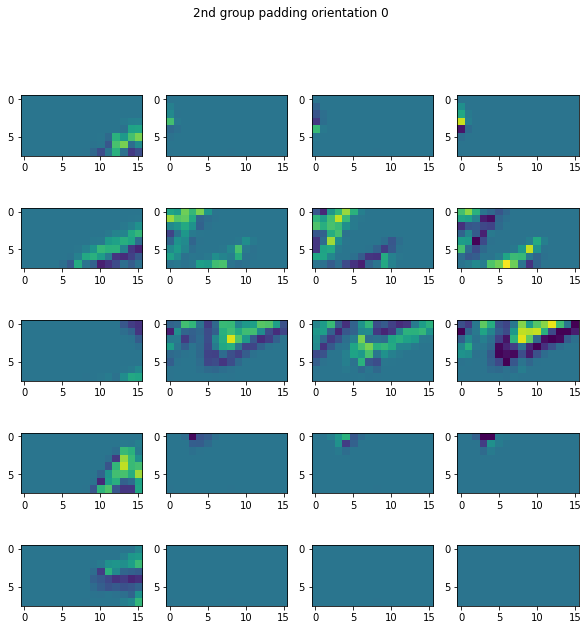

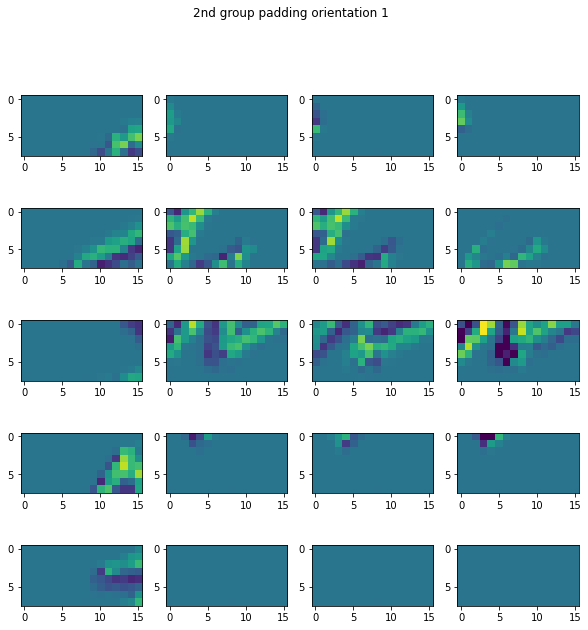

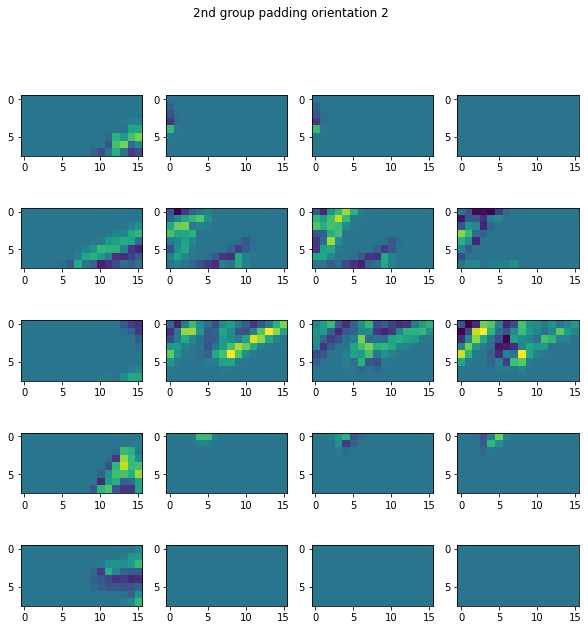

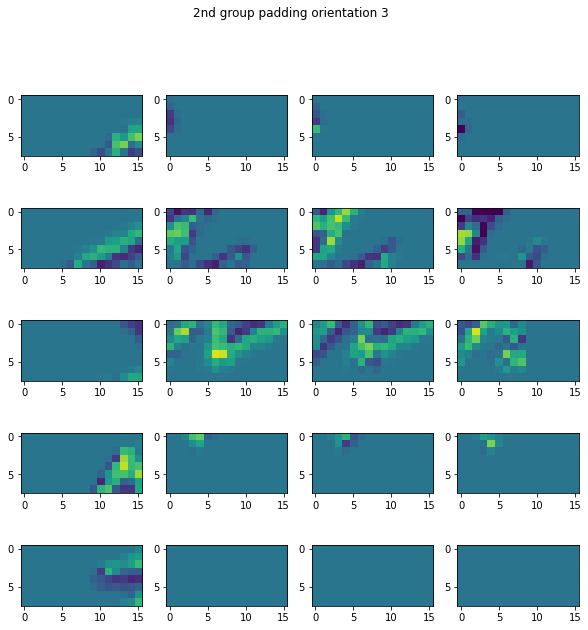

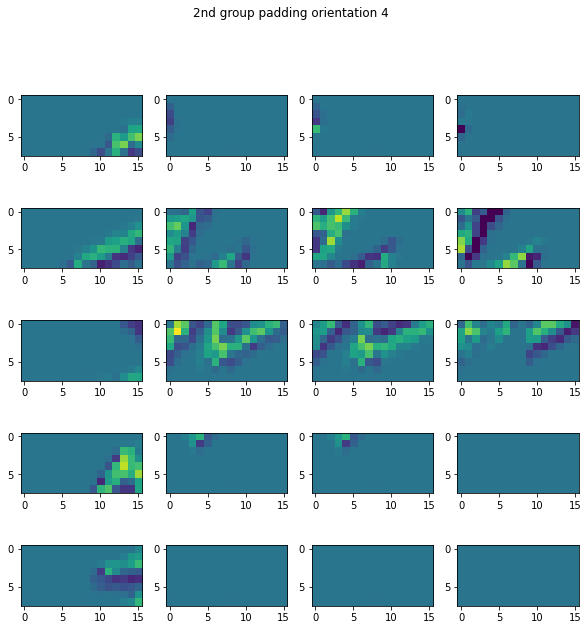

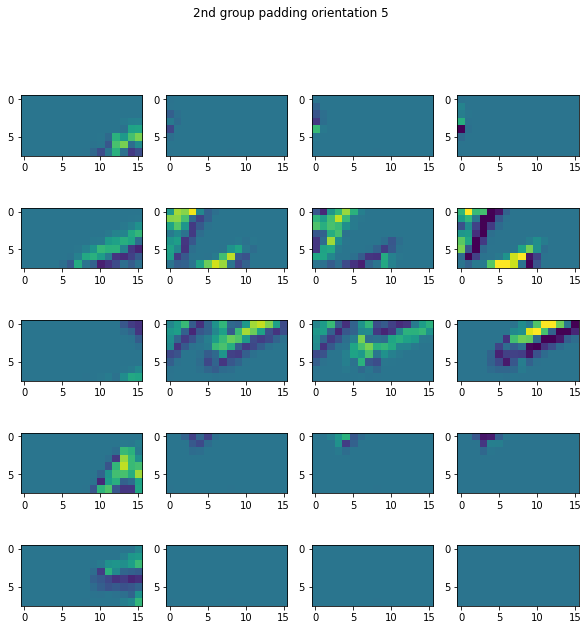

In [54]:
vmin = np.amin(y[:,0,...].numpy())
vmax = np.amax(y[:,0,...].numpy())

y = y.view(y.shape[0],y.shape[1],y.shape[2],5,-1,y.shape[-1])


for j in range(6):
    fig, axs = plt.subplots(5,4,figsize=(10,10))
    
    rot_y = charts_after_ico_rot(y[0,0,...], indices_r3)
    for i in range(5):
        axs[i,0].imshow(y[0,0,0,i,...], vmin=vmin, vmax=vmax)
        axs[i,1].imshow(y[1,0,j,i,...], vmin=vmin, vmax=vmax)
        axs[i,2].imshow(rot_y[0,i,...], vmin=vmin, vmax=vmax)       
        axs[i,3].imshow(y[1,0,j,i,...] - rot_y[0,i,...], vmin=vmin, vmax=vmax)
    
    plt.suptitle("2nd group padding orientation {}".format(j))
    plt.show()
    plt.close()

In [55]:
for i in range(y.shape[-2]):
    for j in range(y.shape[-1]):
        for k in range(5):
            a = np.sort(y[1,0,:,k,i,j])
            b = np.sort(rot_y[:,k,i,j])
            if not (np.isclose(a,b)).all():
                print("ijk =", i,j,k, "\n","arrays:", a,"\n",b)

ijk = 0 0 0 
 arrays: [-0.21690038 -0.0630263  -0.0460493  -0.01379713 -0.00942174  0.2185319 ] 
 [0. 0. 0. 0. 0. 0.]
ijk = 1 1 2 
 arrays: [-0.1116349   0.03366093  1.3416625   2.120235    4.6612625   7.421349  ] 
 [-0.11163509  0.03366033  1.3416622   2.1202345   4.661262    7.42135   ]
ijk = 2 1 0 
 arrays: [-0.28360075 -0.2526341  -0.18347588 -0.00071027  0.01823568  0.37920108] 
 [-0.28360063 -0.25263405 -0.18347594 -0.00071025  0.0182357   0.3792011 ]
ijk = 3 6 2 
 arrays: [-1.5914739   0.08740663  0.4338519   3.5355134   3.880461    3.920974  ] 
 [-1.5914749   0.08740572  0.43385148  3.5355122   3.8804615   3.9209752 ]
ijk = 3 9 2 
 arrays: [-1.0852375   0.01026668  3.1286857   3.3674855   3.926239    5.9424734 ] 
 [-1.0852375   0.01026523  3.128686    3.3674853   3.9262376   5.942474  ]
ijk = 4 8 2 
 arrays: [-2.3499796  -1.7184495   0.07167939  2.5399184   2.806541    7.4281845 ] 
 [-2.34998    -1.7184489   0.07168021  2.5399175   2.8065405   7.4281826 ]
ijk = 5 8 2 
 arrays: 

In [56]:
class icoStridedP6ConvP6(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(icoStridedP6ConvP6, self).__init__()
        self.conv = P6ConvP6(in_channels = in_channels, 
            out_channels=out_channels, 
            kernel_size=3,
            stride=2)


    def forward(self, x):
        """
        Because we have g-padding the strided convolution is not trivial. 
        We need to add rows in order to maintain the right shape. 
        We do this by adding one row at the bottom of each chart. Afterwards we also need to g_pad the results.
        Assume x has shape (batchsize, n_channels, n_stabilizer, n_charts*height, width)
        """
        
        x = self.conv(x[...,1:,:])
        x = F.pad(x,(1,1,1,0)) # pad a single line on the bottom of the image combining the 5 charts
        x = x.view(x.shape[0], x.shape[1], x.shape[2], 5, -1, x.shape[-1])
        x = F.pad(x,(0,0,1,0))
        x = x.view(x.shape[0], x.shape[1], x.shape[2], -1, x.shape[-1])
        return x

torch.Size([50, 18])

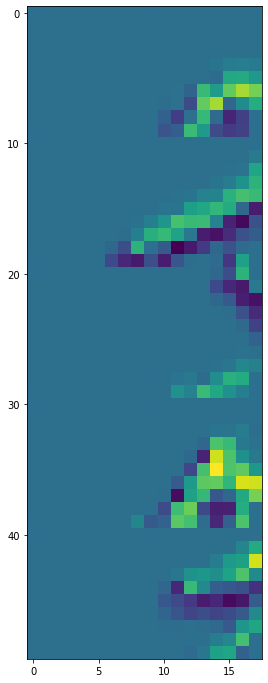

In [57]:
plt.figure(figsize=(6,12))
plt.imshow(x[0,0,0,...].cpu().detach())

x[0,0,0,...].shape
#x

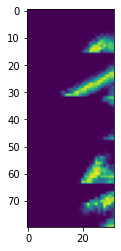

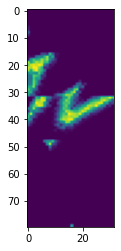

In [58]:
image = projections[0,0,:,:]
image_rot = projections[0,1,:,:]

plt.imshow(image)
plt.show()
plt.close()

plt.imshow(image_rot)
plt.show()
plt.close()

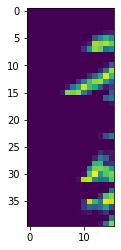

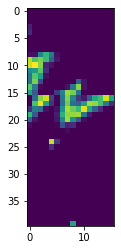

In [59]:
image_ds = image[1::2,::2]
image_rot_ds = image_rot[1::2,::2]


plt.imshow(image_ds)
plt.show()
plt.close()

plt.imshow(image_rot_ds)
plt.show()
plt.close()

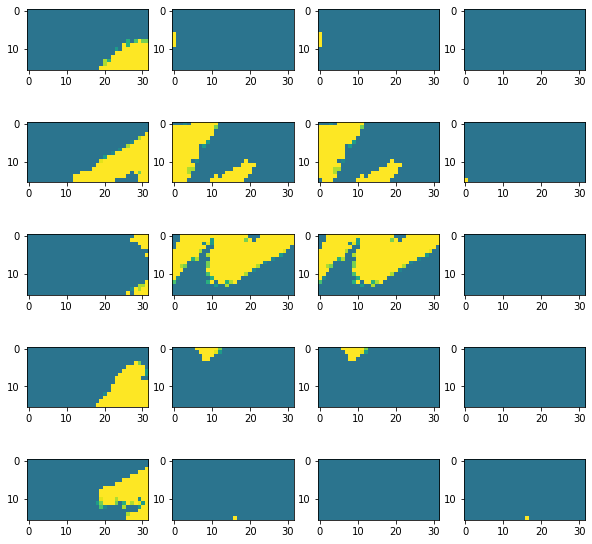

In [60]:
image = image.reshape(5,-1,image.shape[-1])
image_rot = image_rot.reshape(5,-1,image_rot.shape[-1])
image_ds = image_ds.reshape(5,-1,image_ds.shape[-1])
image_rot_ds = image_rot_ds.reshape(5,-1,image_rot_ds.shape[-1])


fig, axs = plt.subplots(5,4,figsize=(10,10))

rot_y = charts_after_ico_rot(image, indices_r4)
for i in range(5):
    axs[i,0].imshow(image[i,...], vmin=vmin, vmax=vmax)
    axs[i,1].imshow(image_rot[i,...], vmin=vmin, vmax=vmax)
    axs[i,2].imshow(rot_y[i,...], vmin=vmin, vmax=vmax)       
    axs[i,3].imshow(image_rot[i,...] - rot_y[i,...], vmin=vmin, vmax=vmax)

plt.show()
plt.close()

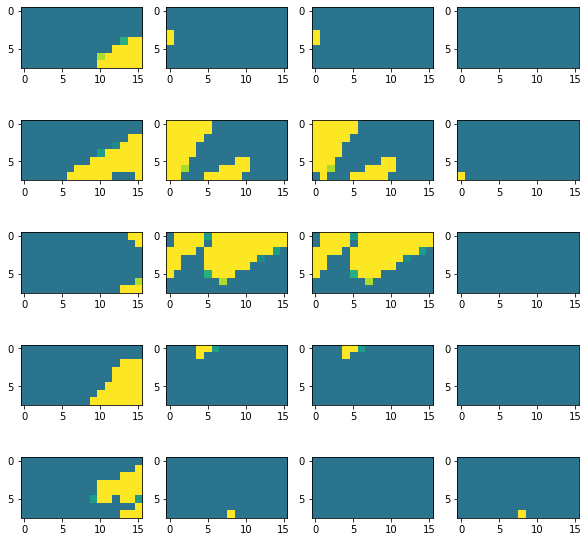

In [61]:

fig, axs = plt.subplots(5,4,figsize=(10,10))

rot_y = charts_after_ico_rot(image_ds, indices_r3)
for i in range(5):
    axs[i,0].imshow(image_ds[i,...], vmin=vmin, vmax=vmax)
    axs[i,1].imshow(image_rot_ds[i,...], vmin=vmin, vmax=vmax)
    axs[i,2].imshow(rot_y[i,...], vmin=vmin, vmax=vmax)       
    axs[i,3].imshow(image_rot_ds[i,...] - rot_y[i,...], vmin=vmin, vmax=vmax)

plt.show()
plt.close()

## Before FC-layers

In [62]:
x = torch.from_numpy(projections.astype('float32').reshape(2,1,1,80,32)).to(DEVICE)

# first we need to pad the input with zeros, to have the right shape to apply g-padding
x = x.view(x.shape[0], 1, 5, -1, x.shape[-1])
x = F.pad(x,(1,1,1,1))
x = x.view(x.shape[0], 1, 1, -1, x.shape[-1])


#convolution 1
g_padding_full(x, in_stab_size=1) # modifies x
x = classifier.conv1(x)
x = F.relu(classifier.BN1(x))
# print("layer 1:", x.shape)        
#convolution 2
g_padding_full(x, in_stab_size=6)
x = classifier.conv2(x)
# print(x.shape)
x = F.relu(classifier.BN2(x))
# print("layer 2:", x.shape) 

#convolution 3
g_padding_full(x, in_stab_size=6)
x = classifier.conv3(x)
x = F.relu(classifier.BN3(x))
# print("layer 3:", x.shape) 

#convolution 4
g_padding_full(x, in_stab_size=6)
x = classifier.conv4(x)
x = F.relu(classifier.BN4(x))
# print("layer 4:", x.shape) 

#convolution 5
g_padding_full(x, in_stab_size=6)
x = classifier.conv5(x)
x = F.relu(classifier.BN5(x))
# print("layer 5:", x.shape) 

#convolution 6
g_padding_full(x, in_stab_size=6)
x = classifier.conv6(x)
x = F.relu(classifier.BN6(x))
# print("layer 6:", x.shape) 

#convolution 7
g_padding_full(x, in_stab_size=6)
x = classifier.conv7(x)
x = F.relu(classifier.BN7(x))
# print("layer 7:", x.shape) 

# pool over orientations and space
g_padding_full(x, in_stab_size=6)
x = plane_group_orientational_max_pooling(x)      

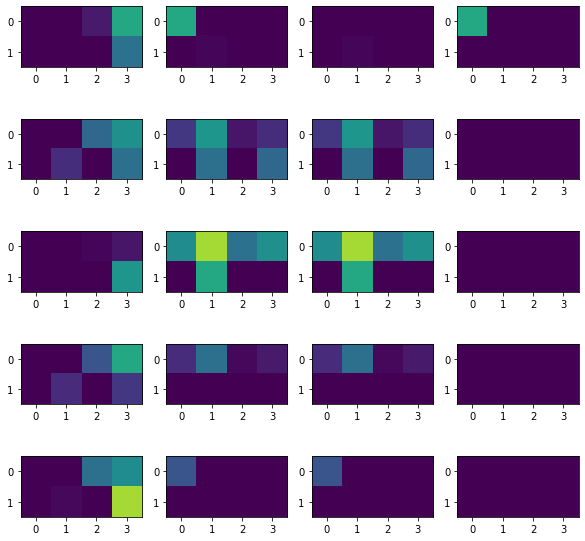

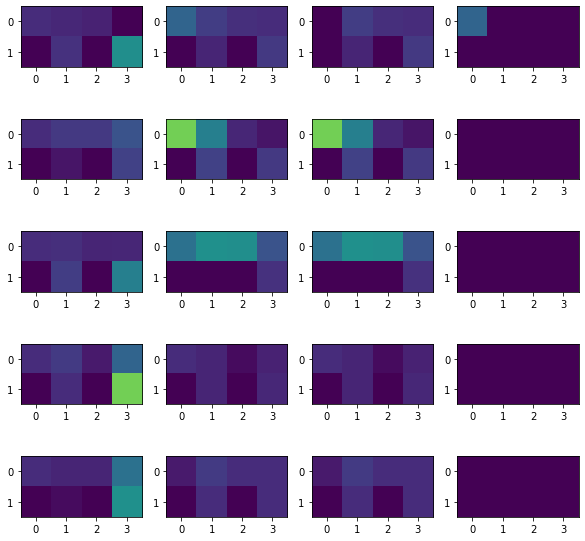

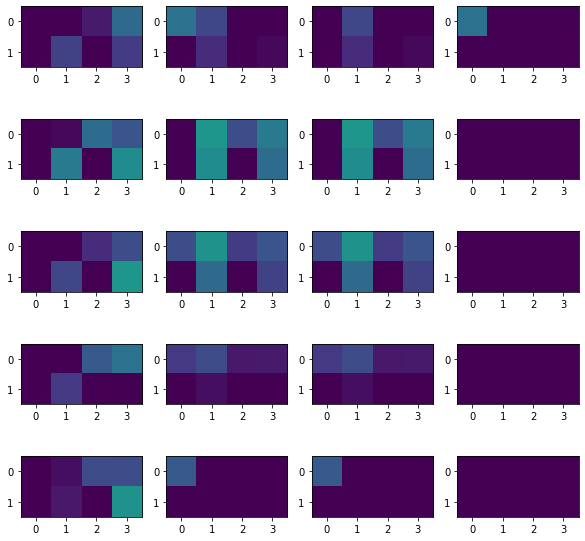

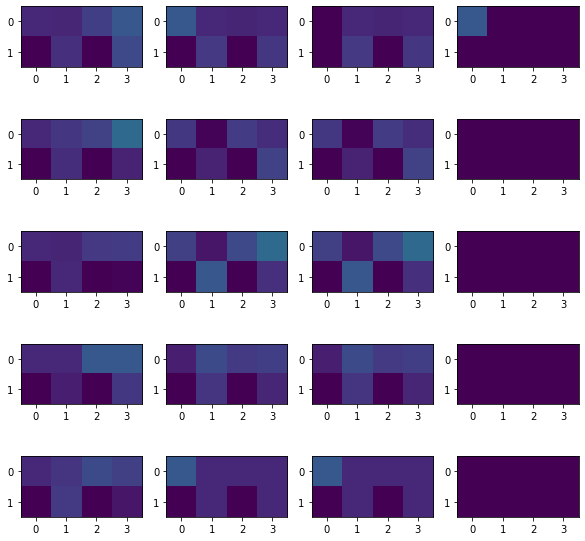

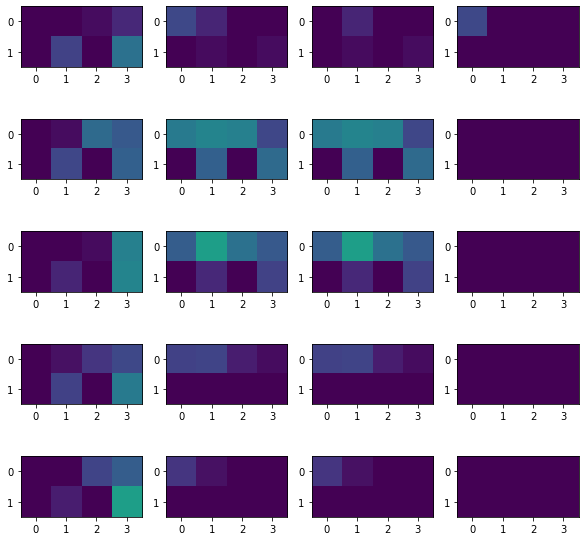

In [63]:
y = get_unpadded_charts(x[:,:,np.newaxis,:,:]).cpu().detach()
vmin = np.amin(y[:,0,...].numpy())
vmax = np.amax(y[:,0,...].numpy())

# now we need new indices because we are at a lower resolution
ico = Icosahedron(r=1, rad=1, c=np.array([0, 0, 0]))
ico_r = Icosahedron(r=1, rad=1, c=np.array([0, 0, 0]), perm=perm)

indices_r1 = get_ico_rot_indices(ico, ico_r)

y = y.view(y.shape[0],y.shape[1],y.shape[2],5,-1,y.shape[-1])

for k in np.random.randint(64,size=(5,)):
    fig, axs = plt.subplots(5,4,figsize=(10,10))
    rot_y = charts_after_ico_rot(y[0,k,0,...], indices_r1)

    for i in range(5):
        axs[i,0].imshow(y[0,k,0,i,...], vmin=vmin, vmax=vmax)
        axs[i,1].imshow(y[1,k,0,i,...], vmin=vmin, vmax=vmax)
        axs[i,2].imshow(rot_y[i,...], vmin=vmin, vmax=vmax)       
        axs[i,3].imshow(y[1,k,0,i,...] - rot_y[i,...], vmin=vmin, vmax=vmax)
    plt.show()
    plt.close()